In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import folium
from folium import GeoJson
from folium.features import GeoJsonTooltip, CustomIcon

In [2]:
# Load the shapefile
file_path = "/content/drive/MyDrive/Colab/LTS/BOS_streets/boston_streets.shp"
gdf = gpd.read_file(file_path)

gdf.shape

(36863, 217)

In [3]:
# Only display relevant columns
selected_columns = ["ADTNEED", "bike_type", "BL_REACH", "BL_WIDTH", "FEDERALFUN", "GT10LO", "GT15L", "GT20LO", "GT30L", "GT5LO", "ILLPARKING", "Lanes_OW", "LocalName", "LT10NO1", "LT15", "LT20NO1", "LT30", "LT56O2", "LT802P2", "MEDIAN", "Name_MDOT", "No_CL", "NUMLANE", "ONEWAY", "PARKALONG", "qDirLanes", "qLTS_Own", "qProtected", "SPEED", "StOperNEU", "STREET_NAM",  "geometry"]

gdf = gdf[selected_columns]
gdf.head()

,ADTNEED,bike_type,BL_REACH,BL_WIDTH,FEDERALFUN,GT10LO,GT15L,GT20LO,GT30L,GT5LO,...,NUMLANE,ONEWAY,PARKALONG,qDirLanes,qLTS_Own,qProtected,SPEED,StOperNEU,STREET_NAM,geometry
0,None,Off-Road Path,0,0,0,0,0,0,0,0,...,0,N/A,0,1,1,1,30,2,None,"LINESTRING (233242.758 895808.486, 233222.49 8..."
1,1P1,None,0,0,5,0,0,0,0,0,...,2,None,0,1,0,0,30,2,HOLLAND STREET,"LINESTRING (230853.372 905550.496, 230815.825 ..."
2,None,0,0,0,1,0,0,0,0,0,...,9,N/A,0,5,6,0,30,0,None,"LINESTRING (237830.56 899715.092, 237875.357 8..."
3,2P2,Sharrow,0,0,3,0,0,0,0,0,...,6,0,1,3,4,1,35,2,None,"LINESTRING (235406.018 902000.001, 235384.466 ..."
4,LOW,0,0,0,7,0,0,0,0,0,...,2,0,0,1,1,0,25,1,None,"LINESTRING (235011.22 899539.093, 235185.812 8..."


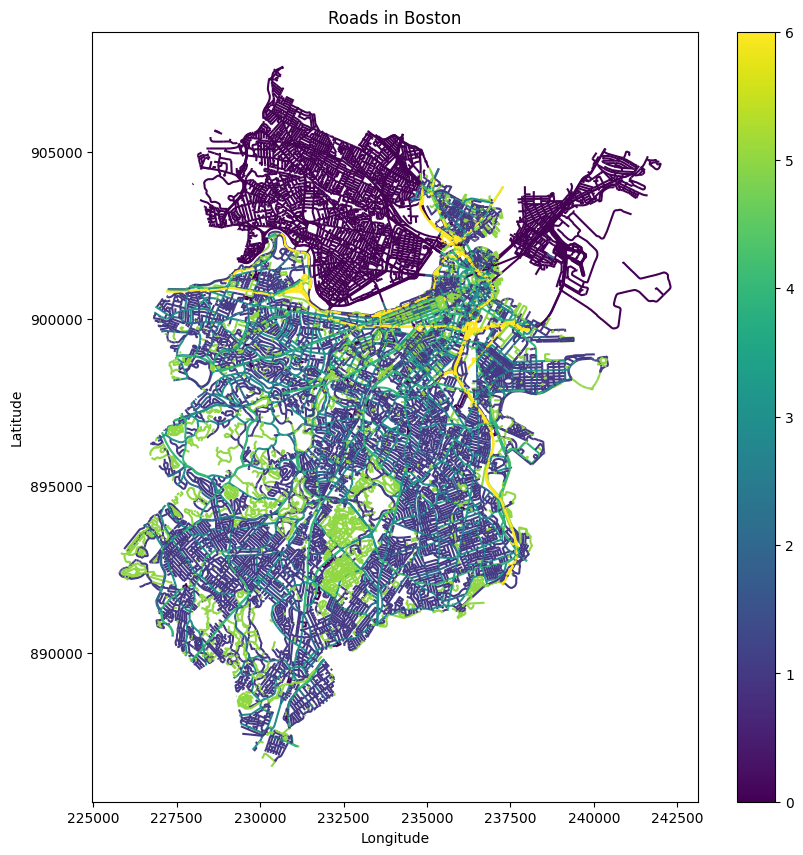

In [4]:
# Plotting the data using a continuous color map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='qLTS_Own', ax=ax, legend=True, cmap='viridis')
ax.set_title("Roads in Boston")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

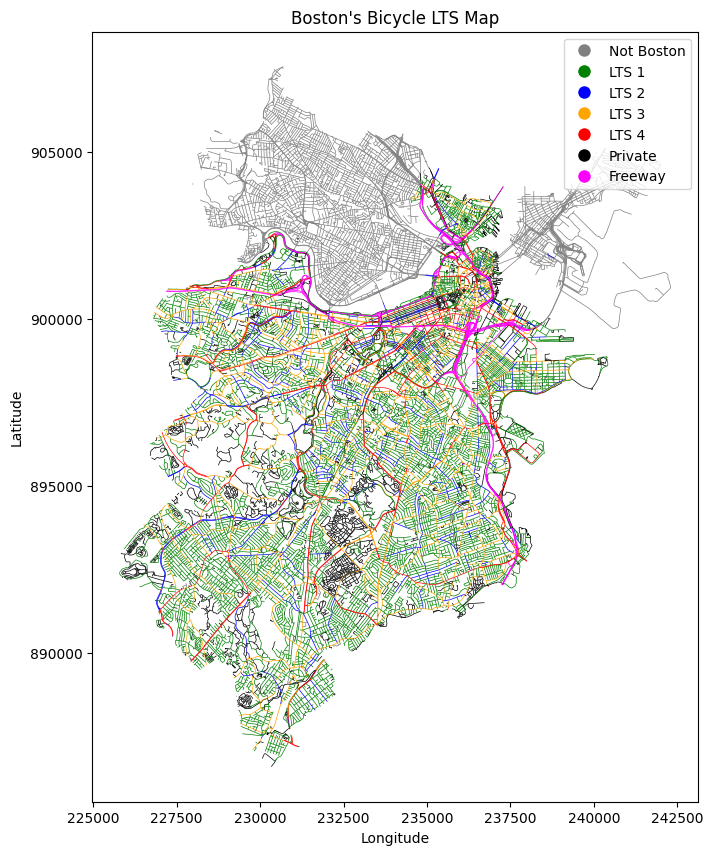

In [5]:
# Treat 'qLTS_Own' as categorical
gdf['qLTS_Own'] = gdf['qLTS_Own'].astype('category')

# Define a custom color map
color_map = {
    0: 'gray',     # outside of Boston
    1: 'green',    # LTS 1
    2: 'blue',     # LTS 2
    3: 'orange',   # LTS 3
    4: 'red',      # LTS 4
    5: 'black',    # Private road
    6: 'magenta'   # Freeway or limited-access road
}

# Create a list of colors corresponding to the categories
colors_list = [color_map[int(val)] for val in gdf['qLTS_Own'].cat.codes]

# Plotting the data with categorical colors
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=colors_list, edgecolor='black', linewidth=0.5)

# Create a custom legend
from matplotlib.lines import Line2D

legend_labels = {
    0: 'Not Boston',
    1: 'LTS 1',
    2: 'LTS 2',
    3: 'LTS 3',
    4: 'LTS 4',
    5: 'Private',
    6: 'Freeway'
}

legend_elements = [Line2D([0], [0], marker='o', color='w', label=legend_labels[k],
                          markerfacecolor=color_map[k], markersize=10) for k in color_map.keys()]
ax.legend(handles=legend_elements, title_fontsize='13')

# Add title and labels
ax.set_title("Boston's Bicycle LTS Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
# Map colors to the 'qLTS_Own' column
gdf['color'] = gdf['qLTS_Own'].map(color_map)

# Create a Folium map centered on Boston
m = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

# JavaScript for adaptive line thickness
adaptive_line_thickness = """
function(feature, layer) {
    var zoom = map.getZoom();
    var weight = zoom >= 14 ? 3 : zoom >= 12 ? 2 : 1;
    layer.setStyle({
        color: feature.properties.color,
        weight: weight,
        opacity: 0.8
    });
}
"""

# Add GeoJson layer with adaptive line thickness
geojson = GeoJson(
    gdf,
    style_function=lambda feature: {
        'color': feature['properties']['color'],
        'weight': 2,
        'opacity': 0.8
    },
    tooltip=GeoJsonTooltip(
        fields=['qLTS_Own'],
        aliases=['LTS Level:'],
        sticky=False
    )
).add_to(m)

# Attach JavaScript for line thickness adjustment
m.get_root().html.add_child(folium.Element(f'<script>{adaptive_line_thickness}</script>'))

# Define custom legend with colored boxes using HTML
legend_html = '''
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 150px; height: auto;
                border:2px solid grey; z-index:9999;
                font-size:14px; background-color:white; padding: 10px;">
    <h4 style="text-align:center; margin-top: 0;">LTS Legend</h4>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:gray; margin-right:5px;"></span>Not Boston</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:green; margin-right:5px;"></span>LTS 1</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:blue; margin-right:5px;"></span>LTS 2</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:orange; margin-right:5px;"></span>LTS 3</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:red; margin-right:5px;"></span>LTS 4</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:black; margin-right:5px;"></span>Private</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:magenta; margin-right:5px;"></span>Freeway</div>
    </div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

In [ ]:
# m.save('boston_lts_map.html')